In [6]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [7]:
%presentation_style

In [8]:
%%capture

%set_random_seed 12

In [9]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Evaluating Simulation-Based Inference</h1>
</div>

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch

import torch
from torch import Tensor, log, ones, zeros
from typing import Callable

from sbi.analysis import run_sbc, sbc_rank_plot
from sbi.inference import SNPE
from sbi.utils import BoxUniform
from sbi.analysis import pairplot

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)

storage = default_remote_storage()
c = get_config(reload=True)

## How can we evaluate the performance of SBI?


- Neural density estimators are accurate only in the limit of infinite training data
- The posteriors we get are only approximations
- How do we know SBI is reliable? 

## Methods to evaluate the performance of SBI


1) Checking neural network training convergence
    - Monitor posterior log-probability of test data pairs $(\theta, x)$ 
2) Posterior predictive checks
    - Test whether the inferred parameters $\theta \sim q(\theta | x_o)$ reproduce the observed data $x_o$
3) Calibration checks
    - Check whether the uncertainties of the inferred posteriors are well-calibrated 


## 1) Neural network training convergence

- Use logging tools like `lightning`, `tensorboard` or `wandb` (weights and biases, wandb.ai) to track training convergence via the validation loss. 
- Validation loss: use unseen data simulated from the prior to evaluate the conditional density estimator: 

```python
validation_loss = -net.log_prob(theta, x)  # - log p(theta | x)
```

- Stop training when `validation_loss` converges (e.g., no decrease for 20 epochs)
```python
trainer = SNPE().append_simulations(theta, x)
net = trainer.train(validation_fractior=0.2, stop_after_epochs=20)

```
- Use `validation_loss` to perform neural architecture search (e.g., for embedding nets)

## Gaussian example

In [11]:
def simulator(theta: Tensor, simulator_scale: float = 0.1) -> Tensor:
    return torch.ones_like(theta) + theta + simulator_scale * torch.randn_like(theta)

# choose prior
num_dims = 3
prior = BoxUniform(-ones(num_dims), ones(num_dims))

# run simulations
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)

# train
trainer = SNPE(prior).append_simulations(theta, x)
trainer.train()
posterior = trainer.build_posterior()

 Neural network successfully converged after 104 epochs.

## 1) Check training convergence

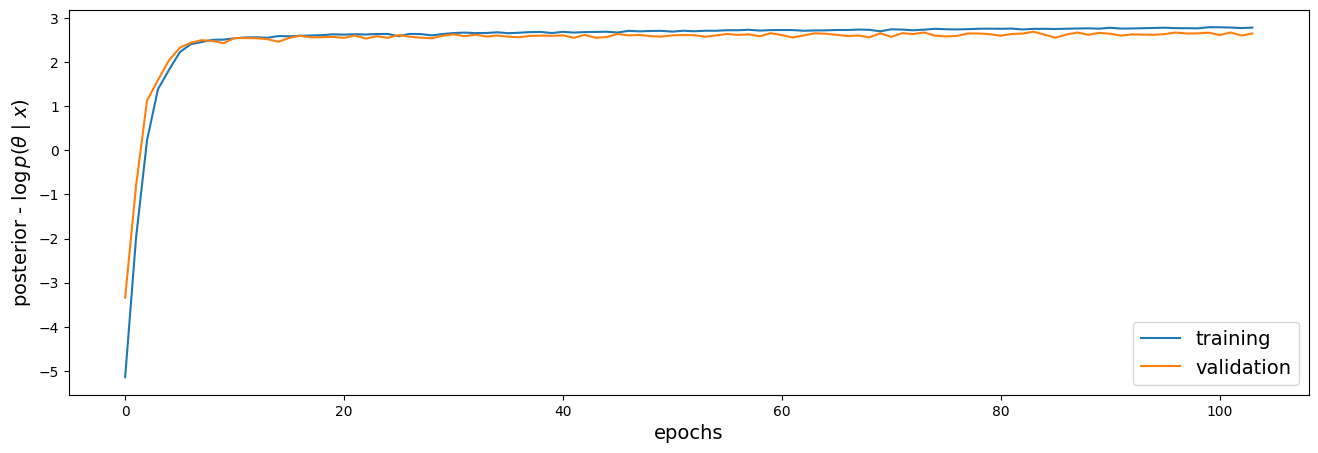

In [12]:
fontsize = 14
plt.figure(figsize=(16, 5))
plt.plot(trainer.summary["training_log_probs"])
plt.plot(trainer.summary["validation_log_probs"])
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("posterior - $\log p(\\theta \mid x)$", fontsize=fontsize)
plt.legend(["training", "validation"], fontsize=fontsize);

## Visualizing the posterior

Parameter space

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

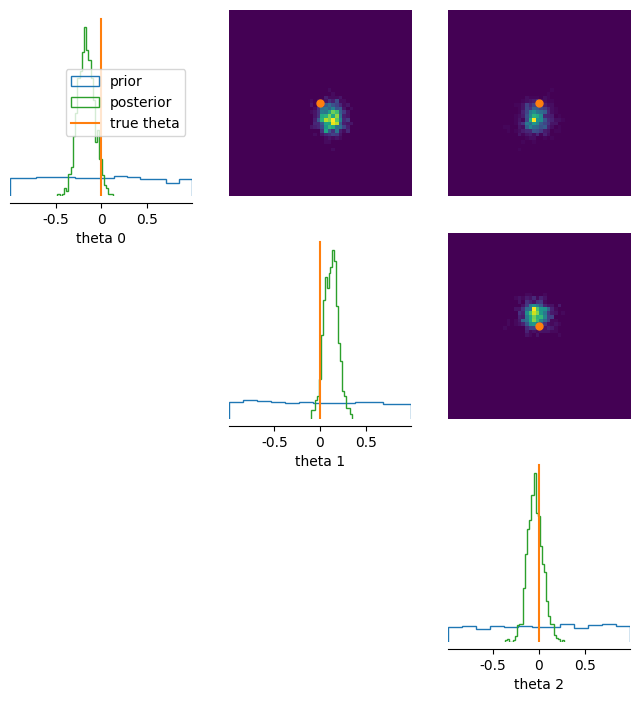

In [13]:
theta_o = zeros(num_dims)
x_o = simulator(theta_o)
num_samples = 1000
posterior_samples = posterior.sample((num_samples,), x=x_o)

pairplot([theta, posterior_samples], points=theta_o, 
         labels=[f"theta {i}" for i in range(num_dims)], samples_labels=["prior", "posterior"], 
         points_labels=["true theta"], legend=True, hist_diag=dict(bins="auto", density=True), figsize=(8, 8),
        );

## 2) Posterior predictive checks

- The posterior characterizes those model parameters that are likely to have generate the observed data $x_o$
- Thus, simulating data with inferred parameters should reproduce $x_o$ ($\pm$ simulator noise)
- Posterior predictive checks: 
    - Simulate data with parameters sampled from the posterior
    - Visually or quantitatively compare to $x_o$
    - If they do not match, something is off! 

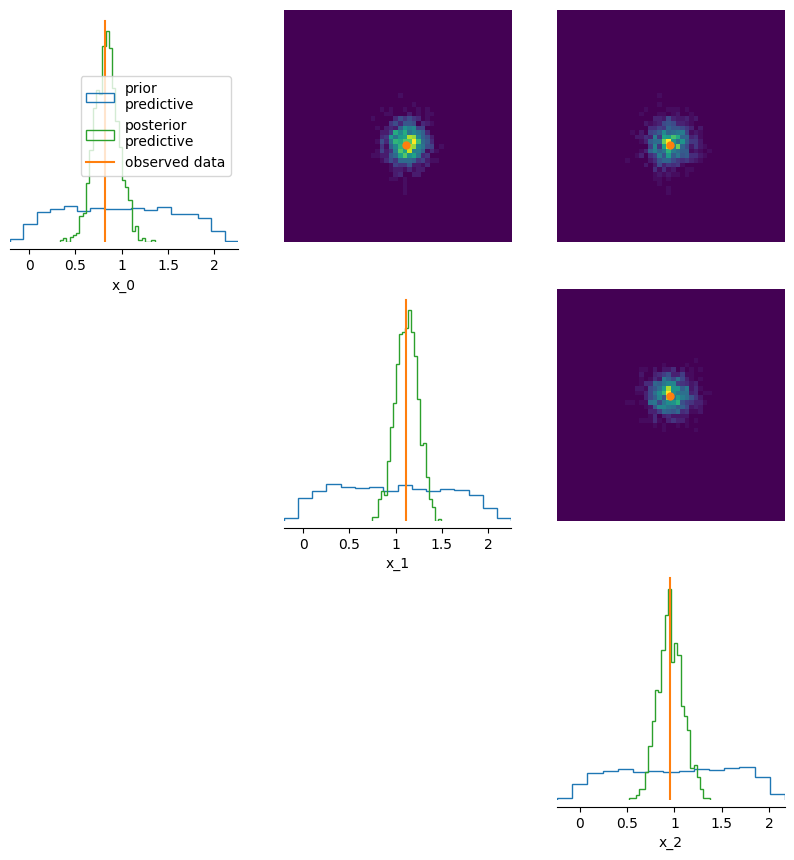

In [14]:
posterior_predictive_samples = simulator(posterior_samples)
pairplot([x, posterior_predictive_samples], points=x_o, labels=[f"x_{i}" for i in range(num_dims)], legend=True,
         samples_labels=["prior\npredictive", "posterior\npredictive"], points_labels=["observed data"], 
         hist_diag=dict(bins="auto", density=True),
        );

## 3) Posterior calibration checks

- Check whether the SBI posterior uncertainties are well-calibrated: whether the posterior is over- or underconfident (on average)
- Indirect check: we do not need access to the true posterior
- Requirements 
    - Access to a set of unseen test data $(\theta, x)$ (~100s)
    - Fast inference for each test data point (computationally feasible only for amortized SBI methods)
    - Fast posterior sampling (computationally demanding for NLE / NRE). 

## Simulation-Based Calibration (SBC)

### Rough idea

- Repeat inference many times with different test data pairs $(\theta_i, x_i)$

$$
\begin{align}
    \theta^* &\sim p(\theta)\\
    x^* &\sim p(x | \theta^*)\\
    \{\theta_1, \ldots \theta_L\} &\sim p_i(\theta | x^*)\\
\end{align}
$$

- Calculate the rank of $\theta_i$ under corresponding posterior $p_i(\theta | x_i)$

$$
\begin{align}
    r_i = \sum_{j=1}^L \mathbb{I}[f(\theta_j) < f(\theta_i^*)] \in [0, L], 
\end{align}
$$

- Check whether distribution of ranks is uniform

## Simulation-Based Calibration (SBC)

### Intuition

- There is uncertainty in the simulator (aleatoric) and in the data (epistemic)
- Posterior is **not centered on true parameter** $\theta_o$
- But $\theta_o$ should be somewhere within the posterior (randomly)
- On average, it should be everywhere within posterior mass (uniform ranks)

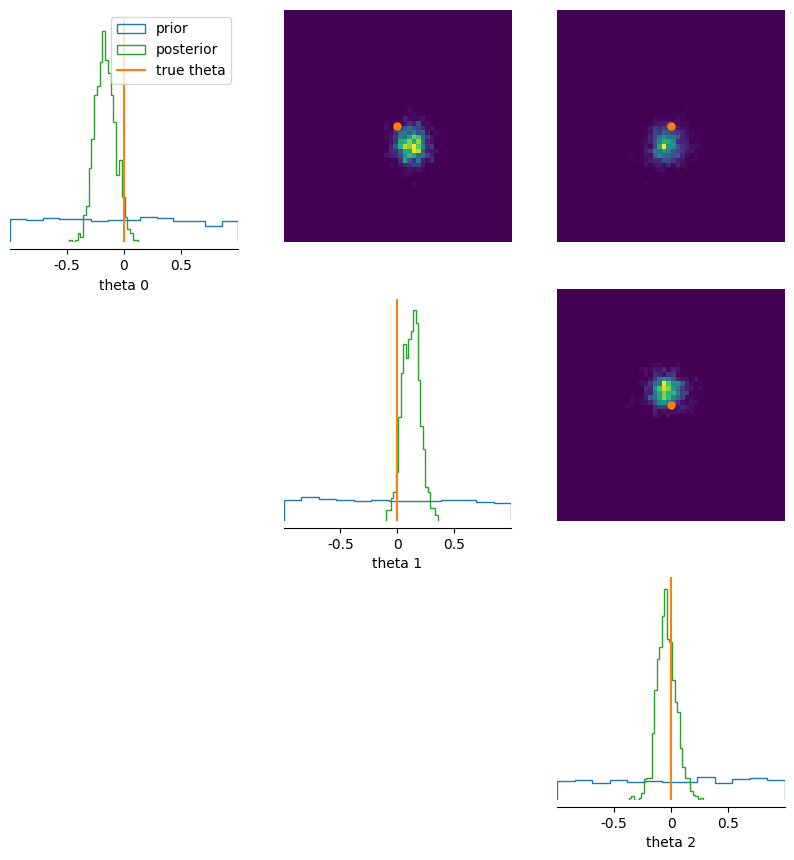

In [15]:
pairplot([theta, posterior_samples], points=theta_o, labels=[f"theta {i}" for i in range(num_dims)],
         samples_labels=["prior", "posterior"], points_labels=["true theta"],
         legend=True, hist_diag=dict(bins="auto", density=True),
        );

## Simulation-Based Calibration

### Interpretation
<img src="_static/images/fig2.4_sbc_illustration.png" alt="Snow" style="width:100%;">

- The posterior is **well-calibrated** only if the ranks are distributed uniformly (necessary condition)
- Shape of rank-distribution gives insight about **mis-calibration**
- Can be gamed by setting posterior=prior (it's not a sufficient condition)



## Example: applying SBC to Gaussian simulator from above

In [16]:
# generate test data set from prior
num_sbc_simulations = 1000
num_posterior_samples = 1000
theta_test = prior.sample((num_sbc_simulations,))
x_test = simulator(theta_test, simulator_scale=0.1)

# run SBC
ranks, dap_samples = run_sbc(theta_test, x_test, posterior, num_posterior_samples=num_posterior_samples)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

## Plot the ranks as an empirical CDF

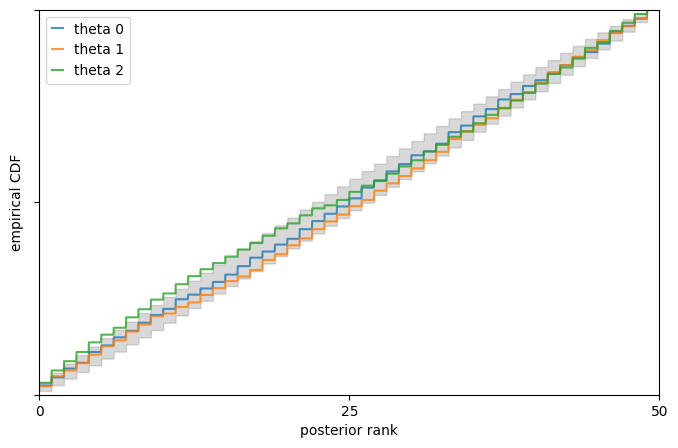

In [17]:
fig, ax = sbc_rank_plot(ranks, num_posterior_samples, 
                        parameter_labels=[f"theta {i}" for i in range(num_dims)])

## Exercise: detecting mis-calibration using SBC

Note: the posterior estimator was trained on data with `simulator_scale=0.1`

1) Task 1: generate slightly **misspecified** test data by using `simulator_scale=0.05`
2) Task 2: run SBC using that test data and plot the distribution of ranks.
3) Task 3: interpret the results

In [18]:
# Your code: 
# generate test theta from the prior
# theta_test = ...
# generate test data from a misspecified simulator
# x_test = ...

# run SBC as above.

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

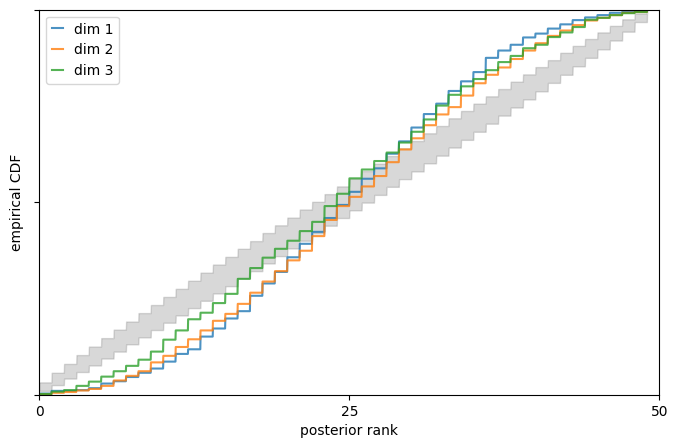

In [19]:
# %load -r 6-13 solutions/solutions_nb_05.py
theta_test = prior.sample((num_sbc_simulations,))
x_test = simulator(theta_test, simulator_scale=0.05)

ranks, dap_samples = run_sbc(
    theta_test, x_test, posterior, num_posterior_samples=num_posterior_samples
)
fig, ax = sbc_rank_plot(ranks, num_posterior_samples)


### Interpretation

- Compare the shape to the middle column in the example Figure above. 
- Because the test data comes from a distribution with smaller variance, our density estimator systematically predicts posteriors with too much variance (dark red in Figure above) -- it is *overdispersed* or underconfident. 
- Optional: Try using test data with higher variance and you will see the opposite pattern -- *underdispersion*.

## Summary

### Reason for SBI evaluation

- Training data is limited
- SBI posteriors are approximate, 
- No access to ground-truth posterior

### Methods for SBI evaluation

1) Checking training convergence of neural-networks via validation-loss (optimize architectures)
2) Posterior predictive checks: test whether data simulator from the posterior matches observation (sufficient)
3) Calibration checks: test whether posterior-uncertainties are well-calibrated

## Learning goals

1) Why do we need to evaluate SBI methods? 
2) What are the current three essential steps of validation? 

## Acknowledgments

- SBI package for code and figures.
- Talts et al. 2018 for their paper on [simulation-based calibration](https://arxiv.org/abs/1804.06788).
- SBC intuition figure taken from [Jan Boelts' PhD thesis](https://publikationen.uni-tuebingen.de/xmlui/handle/10900/143554)

<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h2>Thank you for your attention!</h2>
</div>